In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
from toy_plot_helpers import ToyPlot

In [2]:
import openpathsampling.toy_dynamics as toys
plot = ToyPlot()
pes = (
    toys.toy_pes.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, 0.5]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])
)

plot.contour_range = np.arange(-1.5, 1.0, 0.1)

topology=paths.ToyTopology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

template = paths.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    potential_energy = 0.0, # Important to set energies dimensionless otherwise kcal/mol is default
    kinetic_energy = 0.0,
    topology=topology
)

integ = toys.toy_integrators.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'nsteps_per_frame' : 10
}

toy_eng = toys.toy_engine.ToyEngine(
    options=options,
    template=template
)
toy_eng.initialized = True

toy_eng.current_snapshot = template
paths.PathMover.engine = toy_eng

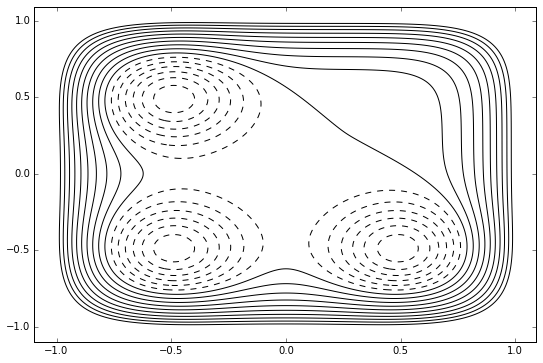

In [3]:
plot.add_pes(pes)
plot.plot()

In [4]:
def xval(snapshot):
    return snapshot.xyz[0][0]

def xprime(snapshot):
    # this only exists until we set up the ability for the order parameter to decrease
    return -snapshot.xyz[0][0]

def yval(snapshot):
    return snapshot.xyz[0][1]
    
opX = paths.CV_Function(name="opX", fcn=xval)
opY = paths.CV_Function(name="opY", fcn=yval)
opXprime = paths.CV_Function(name="opXprime", fcn=xprime)

In [5]:
x_under_min = paths.LambdaVolume(opX, float("-inf"), -0.3)
x_over_max = paths.LambdaVolume(opX, 0.3, float("inf")) 
y_under_min = paths.LambdaVolume(opY, float("-inf"), -0.3)
y_over_max = paths.LambdaVolume(opY, 0.3, float("inf")) 

stateA = x_under_min & y_under_min
stateB = x_over_max & y_under_min
stateC = x_under_min & y_over_max

In [6]:
#plot.add_states([stateA, stateB, stateC])
#plot.plot()

In [7]:
interfacesAB = paths.VolumeFactory.LambdaVolumeSet(opX, float("-inf"), [-0.3, -0.2, -0.1, 0.0])
interfacesAC = paths.VolumeFactory.LambdaVolumeSet(opY, float("-inf"), [-0.3, -0.2, -0.1, 0.0])
interfacesBA = paths.VolumeFactory.LambdaVolumeSet(opXprime, float("-inf"), [-0.3, -0.2, -0.1, 0.0])

In [8]:
retisAB = paths.RETISTransition(stateA, stateB, interfacesAB, orderparameter=opX, name="A->B")
retisAC = paths.RETISTransition(stateA, stateC, interfacesAC, orderparameter=opY, name="A->C")
retisBA = paths.RETISTransition(stateB, stateA, interfacesBA, orderparameter=opXprime, name="B->A")

In [9]:
mistis = paths.MISTISNetwork([retisAB, retisAC, retisBA])

In [10]:
mistis.all_ensembles

In [11]:
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)


In [12]:
# the other option might be to turn this into a class FullBootstrap, but this function seems to work for now
# TODO: move this function into openpathsampling (maybe have a module bootstrap_interfaces?)
import sys
def full_bootstrap(transition, snapshot, engine, extra_interfaces=[], forbidden_states=[], storage=None):
    interface0 = transition.interfaces[0]
    ensemble0 = transition.ensembles[0]
    state = transition.stateA
    first_traj_ensemble = paths.SequentialEnsemble([
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state)),
        paths.AllInXEnsemble(state),
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state) & paths.AllInXEnsemble(interface0)),
        paths.OptionalEnsemble(paths.AllInXEnsemble(interface0)),
        paths.AllOutXEnsemble(interface0),
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state)),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(state))
    ]) & paths.AllOutXEnsemble(paths.join_volumes(forbidden_states))
    #print first_traj_ensemble #DEBUG
    engine.current_snapshot = snapshot
    engine.snapshot = snapshot
    print "Building first trajectory"
    sys.stdout.flush()
    first_traj = engine.generate(engine.current_snapshot, [first_traj_ensemble.can_append])
    print "Selecting segment"
    sys.stdout.flush()
    subtraj = ensemble0.split(first_traj)[0]
    extra_ensembles = [
        paths.TISEnsemble(transition.stateA, transition.stateB, iface, transition.orderparameter)
        for iface in extra_interfaces
    ]
    extra_shooters = [paths.OneWayShootingMover(paths.UniformSelector(), ens) for ens in extra_ensembles]
    print "Sampling " + str(len(transition.ensembles+extra_ensembles)) + " ensembles."
    bootstrap = paths.Bootstrapping(
        storage=storage,
        ensembles=transition.ensembles+extra_ensembles,
        movers=transition.movers['shooting']+extra_shooters,
        trajectory=subtraj
    )
    print "Beginning bootstrapping"
    while len(bootstrap.globalstate) < len(transition.ensembles+extra_ensembles):
        bootstrap.run(20)
    return bootstrap.globalstate


In [13]:
snapA = paths.Snapshot(
    coordinates=[[-0.5, -0.5]],
    velocities=[[0.5, 0.0]]
)
init_AB = full_bootstrap(retisAB, snapA, toy_eng, forbidden_states=[stateC])

DONE! Completed Bootstrapping cycle step 710 in ensemble 4/4 .



In [14]:
snapA = paths.Snapshot(
    coordinates=[[-0.5, -0.5]],
    velocities=[[0.0, 0.5]]
)
init_AC = full_bootstrap(retisAC, snapA, toy_eng, forbidden_states=[stateB])

DONE! Completed Bootstrapping cycle step 15 in ensemble 4/4 .



In [15]:
snapB = paths.Snapshot(
    coordinates=[[0.5, -0.5]],
    velocities=[[-0.5, 0.0]]
)
init_BA = full_bootstrap(retisBA, snapB, toy_eng, forbidden_states=[stateC])

DONE! Completed Bootstrapping cycle step 159 in ensemble 4/4 .



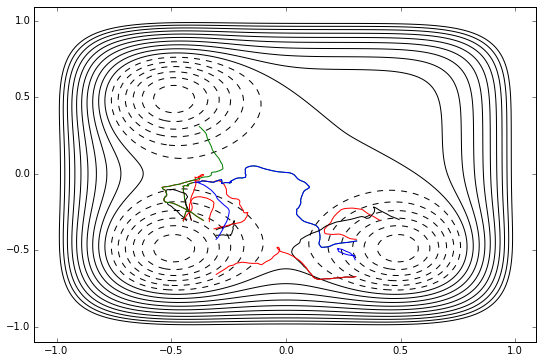

In [16]:
plot.plot([s.trajectory for s in list(init_AB)+list(init_AC)+list(init_BA)])

In [17]:
# TODO: it would be really nice if all of this could be handled somewhat automatically

sset = paths.SampleSet.relabel_replicas_per_ensemble([
        paths.SampleSet(init_AB.samples[:-1]), 
        paths.SampleSet(init_BA.samples[:-1]),
        paths.SampleSet(init_AC.samples)
    ])

sset = paths.SampleSet.translate_ensembles(sset, mistis.all_ensembles)



In [18]:
outer_sset = paths.SampleSet([init.samples[-1] for init in [init_AB, init_BA]])
outer_sample = paths.Sample(
    replica=len(sset),
    trajectory=init_AB.samples[-1].trajectory,
    ensemble=mistis.ms_outers[0]
)
sset = sset.apply_samples([outer_sample])

minus_samples = []
for minus in mistis.minus_ensembles:
    for partial_traj in [s.trajectory for s in sset]:
        if minus._segment_ensemble(partial_traj):
            break
    good_sample = False
    while not good_sample:
        samp = minus.populate_minus_ensemble(
            partial_traj=partial_traj,
            minus_replica_id=-mistis.minus_ensembles.index(minus)-1,
            engine=toy_eng
        )
        good_sample = samp.ensemble(samp.trajectory)
    minus_samples.append(samp)

sset = sset.apply_samples(minus_samples)


In [19]:
storage = paths.storage.Storage("mistis.nc", "w", template=template)
storage.save(mistis)
storage.sync()


In [20]:
mistis_calc = paths.PathSampling(
    storage=storage,
    engine=toy_eng,
    root_mover=mistis.default_movers(),
    globalstate=sset
)
mistis_calc.save_frequency = 100

In [21]:
for s in sset:
    print repr(s.ensemble), s.ensemble(s.trajectory)

<openpathsampling.ensemble.TISEnsemble object at 0x1145043d0> True
<openpathsampling.ensemble.TISEnsemble object at 0x1144893d0> True
<openpathsampling.ensemble.TISEnsemble object at 0x11431f950> True
<openpathsampling.ensemble.TISEnsemble object at 0x114778210> True
<openpathsampling.ensemble.TISEnsemble object at 0x114778610> True
<openpathsampling.ensemble.TISEnsemble object at 0x114778a10> True
<openpathsampling.ensemble.TISEnsemble object at 0x1142efb90> True
<openpathsampling.ensemble.TISEnsemble object at 0x1142eff90> True
<openpathsampling.ensemble.TISEnsemble object at 0x1142fa3d0> True
<openpathsampling.ensemble.TISEnsemble object at 0x1142fa7d0> True
<openpathsampling.ensemble.UnionEnsemble object at 0x114788290> True
<openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x114788250> True
<openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x11478f210> True


In [22]:
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)
mistis_calc.run(200)

DONE! Completed 200 Monte Carlo cycles.

 